In [20]:
import os
import importlib
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

import glob


In [2]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.objects.sim_utils as su
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

In [4]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                        return_missing=True,
                                        create_new=False, return_cells=True)

experiment_list = ['rfs10', 'rfs'] 
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [5]:
do_spherical_correction=False
response_type='dff'
# Get ALL rfdata, including rf-5 and rf-10
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata, no_fit, no_eval = rfutils.aggregate_rfdata(meta, cells0, fit_desc=rf_fit_desc,
                                 reliable_only=False, return_missing=True)
assert float(rfdata[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
        .groupby(['visual_area', 'datakey']).count().max()) == 2

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [8]:
# Combine all rfdata to be AVERAGE or rf-5 or rf-10, WHATEVER we have
rfdf = rfutils.average_rfs(rfdata, keep_experiment=False) # most liberal
# Check that only 1 RF experiment per datakey
assert float(rfdf[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
        .groupby(['visual_area', 'datakey']).count().max())==1
bad_assignment = []
for (dk, ri), g in rfdf.groupby(['datakey', 'cell']):
    if g.shape[0]>1:
        bad_assignment.append((dk, ri))    
bad_assignment       

In [32]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [35]:
POLYS, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=False)
check_rfs

{'20190430_JC078_fov1': [(211.0,
   <shapely.geometry.polygon.Polygon at 0x2b463a2624d0>)],
 '20190509_JC078_fov1': [(53.0,
   <shapely.geometry.polygon.Polygon at 0x2b463a262110>)],
 '20190522_JC089_fov1': [(121.0,
   <shapely.geometry.polygon.Polygon at 0x2b463a262210>)],
 '20190622_JC085_fov1': [(119.0,
   <shapely.geometry.polygon.Polygon at 0x2b463a262350>)],
 '20191017_JC113_fov1': [(75.0,
   <shapely.geometry.polygon.Polygon at 0x2b463a262a50>)]}

<IPython.core.display.Javascript object>


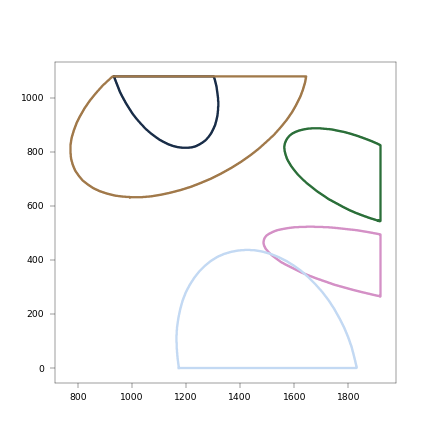

20190430_JC078_fov1
20190509_JC078_fov1
20190522_JC089_fov1
20190622_JC085_fov1
20191017_JC113_fov1


In [42]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(4,4))
col_list = sns.color_palette('cubehelix', n_colors=len(check_rfs))
for col, (dk, check_r) in zip(col_list, check_rfs.items()):
    print(dk)
    for rid, poly1 in check_r:
        ax.plot(*poly1.exterior.xy, color=col)
ax.set_aspect('equal')

## Test loading for DECODE analysis

In [44]:
import analyze2p.decoding as dec

In [169]:
curr_dst_dir = os.path.join(aggregate_dir, 'decoding', 'py3_controls')
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_controls


In [159]:
trial_epoch='plushalf'
responsive_test='nstds'
responsive_thr=10. if responsive_test=='nstds' else 0.05
response_type='dff'
traceid='traces001'
experiment='blobs'

resp_desc='%s-thr-%.2f' % (responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc, experiment, trial_epoch])
print(data_id)

traces001|nstds-thr-10.00|blobs|plushalf


In [52]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]


In [78]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [80]:
# Get all cells in responsive data
cells1 = dec.get_all_responsive_cells(cells0, NDATA0)
# Of responsive cells, get those with RFs
cells_RF = dec.get_cells_with_rfs(cells1, rfdf)

## match rf size

In [82]:
rf_lim='percentile'
# cells_matched = dec.get_cells_with_matched_rfs(cells_RF, sdata, rf_lim=rf_lim,
#                                     response_type=response_type,
#                                     do_spherical_correction=do_spherical_correction)
cells_matched, limits = dec.limit_cells_by_rf(cells_RF, rf_lim=rf_lim, 
                                          rf_metric='fwhm_avg')

lower_lim, upper_lim = limits.loc['lower'].max(), limits.loc['upper'].min()      

In [83]:
print(cells_RF[['visual_area','datakey', 'cell']]\
      .drop_duplicates()['visual_area'].value_counts())

V1    780
Lm    350
Li    247
Name: visual_area, dtype: int64


In [84]:
print(cells_matched[['visual_area','datakey', 'cell']]\
      .drop_duplicates()['visual_area'].value_counts())

V1    733
Lm    284
Li    169
Name: visual_area, dtype: int64


In [115]:
cellids_matched = aggr.unique_cell_df(cells_matched, 
                                           criterion='max', colname='cell')
print(cellids_matched[['visual_area','datakey', 'cell']]\
      .drop_duplicates()['visual_area'].value_counts())

[V1] Animalid does not exist: JC078 
V1    646
Lm    193
Li    119
Name: visual_area, dtype: int64


<IPython.core.display.Javascript object>


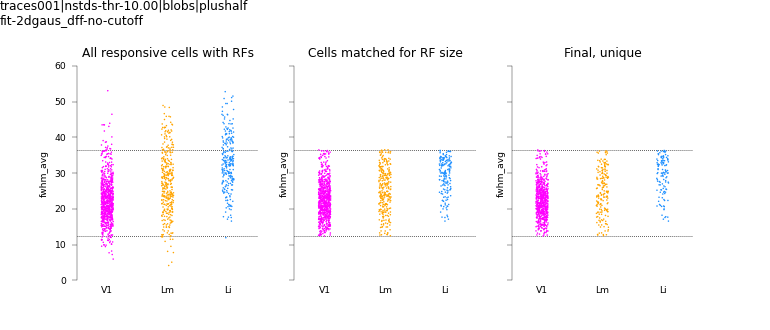

In [170]:
pl.rcParams.update({'axes.titlesize': 8})

fig, axn = pl.subplots(1,3, figsize=(7,3), sharex=True, sharey=True)
ax=axn[0]; ax.set_title('All responsive cells with RFs');
sns.stripplot(x='visual_area', y='fwhm_avg', data=cells_RF, ax=ax,
             hue='visual_area', palette=area_colors, s=1, order=visual_areas)
ax=axn[1]; ax.set_title('Cells matched for RF size');
sns.stripplot(x='visual_area', y='fwhm_avg', data=cells_matched, ax=ax,
             hue='visual_area', palette=area_colors, s=1, order=visual_areas)
ax=axn[2]; ax.set_title('Final, unique');
sns.stripplot(x='visual_area', y='fwhm_avg', data=cellids_matched, ax=ax,
             hue='visual_area', palette=area_colors, s=1, order=visual_areas)
for ax in axn:
    ax.legend_.remove()
    ax.axhline(y=lower_lim, ls=':', color='k', lw=0.5)
    ax.axhline(y=upper_lim, ls=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylim([0, 60])
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.8)
    
pplot.label_figure(fig, '%s\n%s' % (data_id, rf_fit_desc))

pl.savefig(os.path.join(curr_dst_dir, 'rf_sizes_filtered.svg'))


#### Compare with overlap=0 (default)

In [88]:
overlap_thr=0.0
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                do_spherical_correction=do_spherical_correction)
rfpolys, _ = su.load_rfpolys(fit_desc)
cells_overlap = dec.calculate_overlaps(cells_RF, rfpolys, overlap_thr=overlap_thr)

In [89]:
print(cells_overlap[['visual_area','datakey', 'cell']]\
      .drop_duplicates()['visual_area'].value_counts())

V1    780
Lm    350
Li    247
Name: visual_area, dtype: int64


In [117]:
cellids_overlap = aggr.unique_cell_df(cells_overlap, 
                                           criterion='max', colname='cell')
print(cellids_overlap[['visual_area','datakey', 'cell']]\
      .drop_duplicates()['visual_area'].value_counts())

[V1] Animalid does not exist: JC078 
V1    682
Lm    231
Li    169
Name: visual_area, dtype: int64


In [119]:
cellids_matched['global_ix'] = [int(cells1[(cells1.visual_area==va)
                                        & (cells1.datakey==dk) 
                                        & (cells1['cell']==rid)]['global_ix'].unique()) \
                                        for va, dk, rid \
                                        in cellids_matched[['visual_area', 'datakey', 'cell']].values]

In [120]:
cellids_overlap['global_ix'] = [int(cells1[(cells1.visual_area==va)
                                        & (cells1.datakey==dk) 
                                        & (cells1['cell']==rid)]['global_ix'].unique()) \
                                        for va, dk, rid \
                                        in cellids_overlap[['visual_area', 'datakey', 'cell']].values]

<IPython.core.display.Javascript object>


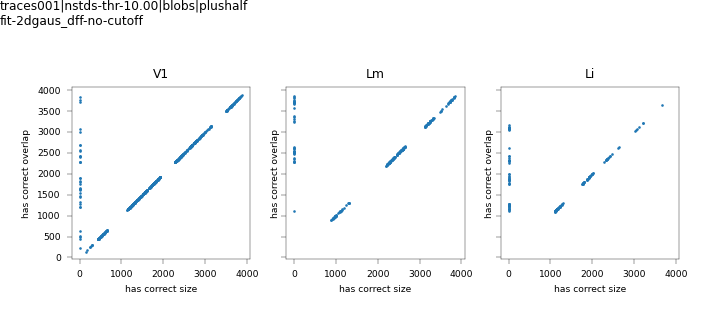

In [172]:
ov_wrong_size={}
sz_wrong_overlap={}
fig, axn = pl.subplots(1,3, sharex=True, sharey=True, figsize=(6.5, 3))
for ax, va in zip(axn.flat, visual_areas):
    sz_ = sorted(cellids_matched[(cellids_matched.visual_area==va)]['global_ix'])
    ov_ = sorted(cellids_overlap[(cellids_overlap.visual_area==va)]['global_ix'])
    all_ = list(sorted(np.union1d(sz_, ov_)))
    sz_matched = np.array([ri if ri in sz_ else -1 for ri in all_])
    ov_matched = np.array([ri if ri in ov_ else -1 for ri in all_])
    sz_wrong_overlap[va] = [all_[i] for i in np.where(sz_matched==-1)[0]]
    ov_wrong_size[va] = [all_[i] for i in np.where(ov_matched==-1)[0]]
    ax.scatter(sz_matched, ov_matched,s=2, marker='.')
    ax.set_title(va)
    ax.set_xlabel('has correct size')
    ax.set_ylabel('has correct overlap')
for ax in axn:
    ax.set_aspect('equal')
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, rf_fit_desc))

pl.savefig(os.path.join(curr_dst_dir, 'passcells_overlap_vs_sizematched.svg'))


In [150]:
cnts_szmatched = cellids_matched['visual_area'].value_counts()
cnts_overlap = cellids_overlap['visual_area'].value_counts()

for va, clist in sz_wrong_overlap.items():
    print(va, len(clist))
    assert cnts_overlap[va] - cnts_szmatched[va] == len(clist)

V1 36
Lm 38
Li 50


<IPython.core.display.Javascript object>


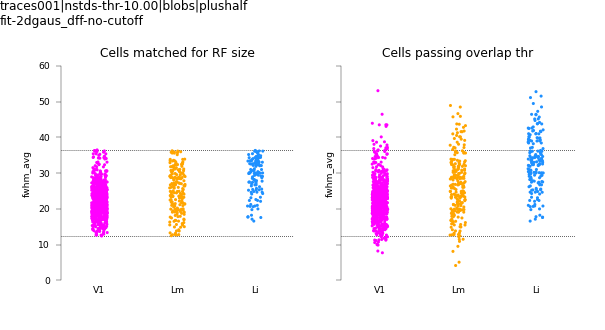

In [175]:
fig, axn = pl.subplots(1,2, figsize=(5.5,3), sharex=True, sharey=True)
ax=axn[0]; ax.set_title('Cells matched for RF size');
sns.stripplot(x='visual_area', y='fwhm_avg', data=cellids_matched, ax=ax,
             hue='visual_area', palette=area_colors, s=2, order=visual_areas)
ax=axn[1]; ax.set_title('Cells passing overlap thr');
sns.stripplot(x='visual_area', y='fwhm_avg', data=cellids_overlap, ax=ax,
             hue='visual_area', palette=area_colors, s=2, order=visual_areas)
for ax in axn:
    ax.legend_.remove()
    ax.axhline(y=lower_lim, ls=':', color='k', lw=0.5)
    ax.axhline(y=upper_lim, ls=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylim([0, 60])
sns.despine(bottom=True, trim=True)
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, rf_fit_desc))

pl.savefig(os.path.join(curr_dst_dir, 'passcells_compare_rfsize.svg'))


## overlap

In [12]:
response_type='dff'
do_spherical_correction=False
rfdf = dec.get_rfdf(cells0, sdata, response_type=response_type,
                do_spherical_correction=do_spherical_correction)
cells_RF = dec.get_cells_with_rfs(cells0, rfdf)
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                do_spherical_correction=do_spherical_correction)
rfpolys, _ = su.load_rfpolys(fit_desc)
# cells_pass = calculate_overlaps(cells_RF, rfpolys, overlap_thr=overlap_thr)

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [13]:
va='V1'
dk='20191006_JC110_fov1'
experiment='blobs'
rfs_ = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()

In [265]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [266]:
curr_rfs = rfs_.copy()
curr_rfs.index = rfs_['cell'].values
curr_rfs['poly'] = None
rois_ = curr_rfs['cell'].unique()

curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
if len(curr_polys)>0:
    curr_polys.index=curr_polys['cell'].values
    curr_rfs.loc[curr_polys.index, 'poly'] = curr_polys['poly']

overlaps_ = su.calculate_overlaps_fov(dk, curr_rfs,
                                      experiment=experiment, resolution=[1920, 1080])

In [267]:
overlaps_.head()

,cell,stimulus,area_overlap,perc_overlap
0,4.0,"(0, 10.0, 30.0, 0.0)",5919.0,0.044097
1,4.0,"(0, 20.0, 30.0, 0.0)",23756.5,0.176986
2,4.0,"(0, 30.0, 30.0, 0.0)",45087.0,0.335899
3,4.0,"(0, 40.0, 30.0, 0.0)",65878.5,0.490796
4,4.0,"(0, 50.0, 30.0, 0.0)",82813.5,0.616961


#### Validate

In [229]:
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
images = su.load_stimuli()   

In [268]:
# stimulus polygons
stim_polys = su.get_stimulus_polys(dk, experiment, create_new=False)   
stim_polys.head()

,poly,stimulus,morphlevel,size,xpos,ypos
0,"POLYGON ((1439 463, 1438 464, 1434 464, 1433 4...","(0, 10.0, 30.0, 0.0)",0,10.0,30.0,0.0
1,"POLYGON ((1435 386, 1434 387, 1427 387, 1426 3...","(0, 20.0, 30.0, 0.0)",0,20.0,30.0,0.0
2,"POLYGON ((1424 310, 1423 311, 1420 311, 1419 3...","(0, 30.0, 30.0, 0.0)",0,30.0,30.0,0.0
3,"POLYGON ((1427 233, 1426 234, 1418 234, 1417 2...","(0, 40.0, 30.0, 0.0)",0,40.0,30.0,0.0
4,"POLYGON ((1424 156, 1423 157, 1412 157, 1411 1...","(0, 50.0, 30.0, 0.0)",0,50.0,30.0,0.0


In [269]:
rfs_ = su.params_deg_to_pixels(curr_rfs) # Convert RF params to pixel space

In [270]:
# select cell
rid = 4
rf_screen = su.rf_to_screen(rid, rfs_[rfs_['cell']==rid])

# Select a stimulus
mp=0
xp=30
yp=0
sz=30

stim = images['M%i' % mp].copy()
stimkey_str = '_'.join([mp, sz, xp, yp])
stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))

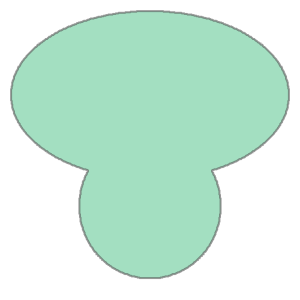

In [271]:
stim_polys[stim_polys['stimulus']==stimkey_str]['poly'].iloc[0]

In [272]:
overlaps_['stimulus']==stimkey_str

0     False
1     False
2      True
3     False
4     False
      ...  
40    False
41    False
42    False
43    False
44    False
Name: stimulus, Length: 4455, dtype: bool

In [273]:
import cv2
im = stim.copy()

In [274]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [275]:
# resize_image_to_coords(im, size_deg=30, pix_per_deg=16.05, aspect_scale=1.747)
size_deg=50
pix_per_deg=16.05
aspect_scale=1.747

ref_dim = max(im.shape)    

<IPython.core.display.Javascript object>


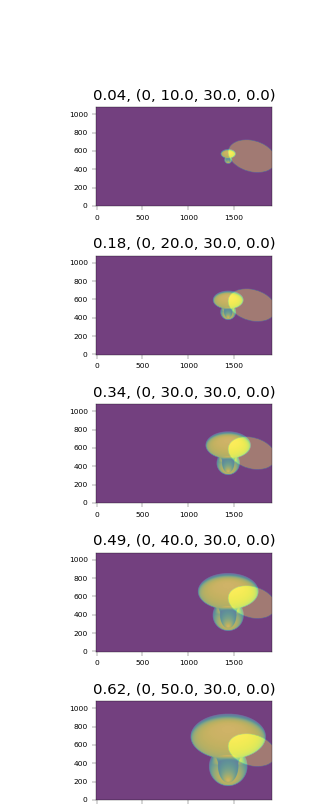

In [277]:
%matplotlib notebook
rf_screen = su.rf_to_screen(rid, rfs_[rfs_['cell']==rid])

sizes = sorted(sdf['size'].unique())
fig, axn = pl.subplots(5,1, figsize=(4, 10))
for ax, sz in zip(axn.flat, sizes):
    stimkey_str = '_'.join([mp, sz, xp, yp])
    stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))
    # -----------------------------
    ax.imshow(rf_screen, alpha=0.5)
    ax.imshow(stim_screen, alpha=0.5)
    perc = float(overlaps_[(overlaps_['cell']==rid) 
                   & (overlaps_['stimulus']==stimkey_str)]['perc_overlap'])
    ax.set_title('%.2f, %s' % (perc, stimkey_str))
    ax.invert_yaxis()
pl.subplots_adjust(hspace=0.5)

In [48]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [49]:
resolution=[1080, 1920]
lin_x, lin_y = hutils.get_lin_coords(resolution=resolution)

In [173]:
#stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))
sz=50
xp = -30
yp= -20
stimkey_str = '_'.join([mp, sz, xp, yp])

# im_r = resize_image_to_coords()
resize_factor = ((sz*pix_per_deg) / ref_dim ) / pix_per_deg 
scale_factor = resize_factor * aspect_scale
im_r = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)      

# Get extent and draw: 
# stim_screen = place_stimulus_on_screen()
stim_extent=[-im_r.shape[1]/2. + xp, im_r.shape[1]/2. + xp,
             -im_r.shape[0]/2. + yp, im_r.shape[0]/2. + yp]
stim_extent

[-73.5, 13.5, -45.0, 5.0]

In [174]:
az_values = lin_x[0,:]
linx_min, linx_max = min(az_values), max(az_values)
xdim_pix = hutils.convert_range([stim_extent[0], stim_extent[1]], 
                     oldmin=linx_min, oldmax=linx_max, 
                     newmin=0, newmax=resolution[1]) #liny_min)
el_values = lin_y[:, 0][::-1]
liny_min, liny_max = min(el_values), max(el_values)
ydim_pix = hutils.convert_range([stim_extent[2], stim_extent[3]], 
                     oldmin=liny_min, oldmax=liny_max, 
                     newmin=0, newmax=resolution[0]) #liny_min)
xmin, xmax = (int(round(i)) for i in xdim_pix)
ymin, ymax = (int(round(i)) for i in ydim_pix)
nw = int(xmax-xmin)
nh = int(ymax-ymin)
im_r2 = cv2.resize(im, (nw, nh))
im_r2.shape

(803, 1399)

In [175]:
stim_extent

[-73.5, 13.5, -45.0, 5.0]

In [176]:
print("x-min: idx %i| val %.2f | true %.2f" % (xmin, az_values[xmin], stim_extent[0]))
print("x-max: idx %i| val %.2f | true %.2f" % (xmax, az_values[xmax], stim_extent[1]))

print("y-min: idx %i| val %.2f | true %.2f" % (ymin, el_values[ymin], stim_extent[2]))
print("y-max: idx %i| val %.2f | true %.2f" % (ymax, el_values[ymax], stim_extent[3]))

x-min: idx -222| val 45.95 | true -73.50
x-max: idx 1177| val 13.53 | true 13.50
y-min: idx -183| val 22.27 | true -45.00
y-max: idx 620| val 5.01 | true 5.00


In [177]:
ymin, ymax

(-183, 620)

In [178]:
ymax - sim_screen.shape[0]

-460

In [179]:
sim_screen = np.zeros(lin_x.shape)
# Check x-dimension
im0 = im_r2.copy()
if xmax>sim_screen.shape[1]: # too far on right side
    trim = xmax - sim_screen.shape[1] # how much beyond are we
    im0 = im_r2[:, 0:(nw-trim)] # trim image 
    xmax = sim_screen.shape[1]
if xmin<0: # Too far on left side
    trim = abs(xmin)
    im0 = im_r2[:, trim:]
    xmin = 0
# Check vertical dimension
im1 = im0.copy()
if ymax>sim_screen.shape[0]: # too far at the top
    trim = ymax - sim_screen.shape[0]
    im1 = im0[trim:, :]
    ymax = sim_screen.shape[0]
if ymin<0: # too far on bottom
    trim = abs(ymin)
    im1 = im0[0:(nh-trim), :]
    ymin = 0
sim_screen[ymin:ymax, xmin:xmax] = np.flipud(im1)

<IPython.core.display.Javascript object>


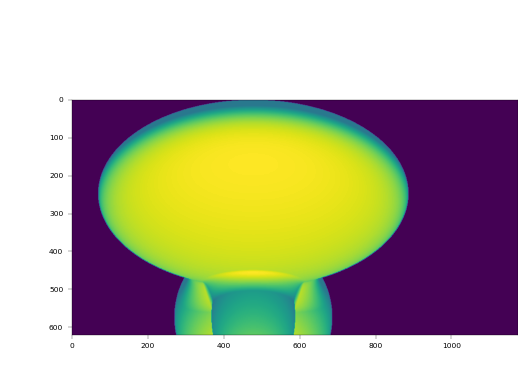

In [180]:
pl.figure()
pl.imshow(im1)

<IPython.core.display.Javascript object>


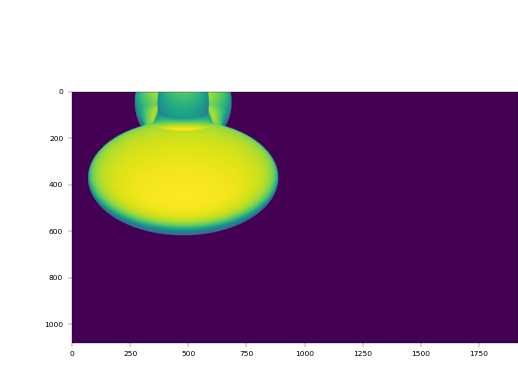

In [181]:
fig, ax= pl.subplots()
ax.imshow(sim_screen)
#ax.invert_yaxis()

In [223]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

<IPython.core.display.Javascript object>


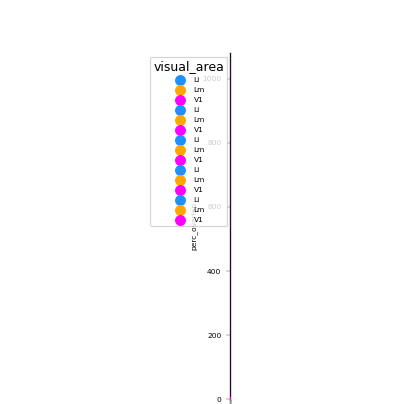

In [284]:
%matplotlib notebook
sizes = sorted(sdf['size'].unique())
fig, ax = pl.subplots(figsize=(5,5))
for sz in sizes[0:]:
    stimkey_str = '_'.join([mp, sz, xp, yp])
    stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))
    # -----------------------------
    ax.imshow(stim_screen, alpha=0.5)
ax.invert_yaxis()

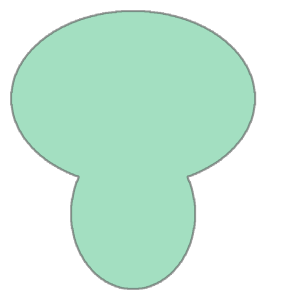

In [114]:
stimkey_str = '(%i, %.1f, %.1f, %.1f)' % (mp, 50, xp, yp)

stim_poly = stim_polys[stim_polys['stimulus']==stimkey_str]['poly'].values[0]
#rfutils.calculate_overlap(rf_poly, cval['poly'].iloc[0],
stim_poly

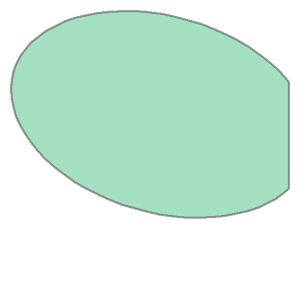

In [102]:
rid = 4
rf_poly = curr_rfs[curr_rfs['cell']==rid]['poly'].values[0]
rf_poly

In [103]:
rfutils.calculate_overlap(rf_poly, stim_poly)

,poly1,poly2,area_overlap,perc_overlap
0,poly1,poly2,0.04042,0.358985


In [85]:
skey = overlaps_['stimulus'].values[0]
stim_poly = stim_polys[stim_polys['stimulus']==skey]
stim_poly['poly'].values[0]

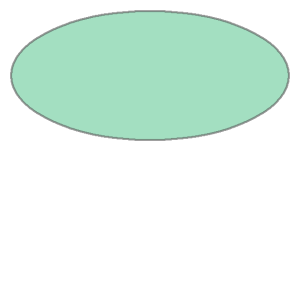

In [60]:
rpoly

In [32]:
r_

,datakey,animalid,session,cell,x0,y0,fwhm_x,fwhm_y,theta,offset,...,minor_axis,anisotropy,theta_Mm_c,aniso_index,visual_area,experiment,x0_pix,y0_pix,fwhm_x_pix,fwhm_y_pix
197.0,20190508_JC083_fov1,JC083,20190508,197.0,53.957145,2.548797,27.746813,13.209007,0.060078,-0.005116,...,5.620854,0.354963,0.060078,-0.312338,Lm,average_rfs,1827,581,445.336347,212.004559
197.0,20190508_JC083_fov1,JC083,20190508,197.0,53.957145,2.548797,27.746813,13.209007,0.060078,-0.005116,...,5.620854,0.354963,0.060078,-0.312338,V1,average_rfs,1827,581,445.336347,212.004559


## Recalculate stim polys

In [334]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [335]:
blob_meta = sdata[sdata['experiment']=='blobs']

In [336]:
for dk, g in blob_meta.groupby(['datakey']):
    stim_polys = su.get_stimulus_polys(dk, 'blobs', create_new=True)

... (20190306_JC061_fov3) creating stimulus polys
... (20190314_JC070_fov1) creating stimulus polys
... (20190315_JC070_fov1) creating stimulus polys
... (20190316_JC070_fov1) creating stimulus polys
... (20190319_JC067_fov1) creating stimulus polys
... (20190320_JC067_fov1) creating stimulus polys
... (20190321_JC070_fov1) creating stimulus polys
... (20190322_JC073_fov1) creating stimulus polys
... (20190327_JC073_fov1) creating stimulus polys
... (20190420_JC076_fov1) creating stimulus polys
... (20190422_JC076_fov1) creating stimulus polys
... (20190430_JC078_fov1) creating stimulus polys
... (20190501_JC076_fov1) creating stimulus polys
... (20190504_JC078_fov1) creating stimulus polys
... (20190506_JC080_fov1) creating stimulus polys
... (20190507_JC083_fov1) creating stimulus polys
... (20190508_JC083_fov1) creating stimulus polys
... (20190509_JC078_fov1) creating stimulus polys
... (20190510_JC083_fov1) creating stimulus polys
... (20190511_JC083_fov1) creating stimulus polys


In [337]:
stim_polys

,poly,stimulus,morphlevel,size,xpos,ypos
0,"POLYGON ((1434 383, 1433 384, 1430 384, 1429 3...",0_10_30_-5,0,10.0,30.0,-5.0
1,"POLYGON ((1435 306, 1434 307, 1427 307, 1426 3...",0_20_30_-5,0,20.0,30.0,-5.0
2,"POLYGON ((1424 230, 1423 231, 1420 231, 1419 2...",0_30_30_-5,0,30.0,30.0,-5.0
3,"POLYGON ((1427 152, 1426 153, 1418 153, 1417 1...",0_40_30_-5,0,40.0,30.0,-5.0
4,"POLYGON ((1424 76, 1423 77, 1412 77, 1411 78, ...",0_50_30_-5,0,50.0,30.0,-5.0
5,"POLYGON ((1435 382, 1434 383, 1432 383, 1431 3...",14_10_30_-5,14,10.0,30.0,-5.0
6,"POLYGON ((1434 304, 1433 305, 1428 305, 1427 3...",14_20_30_-5,14,20.0,30.0,-5.0
7,"POLYGON ((1430 227, 1429 228, 1425 228, 1424 2...",14_30_30_-5,14,30.0,30.0,-5.0
8,"POLYGON ((1426 149, 1425 150, 1419 150, 1418 1...",14_40_30_-5,14,40.0,30.0,-5.0
9,"POLYGON ((1422 72, 1421 73, 1413 73, 1412 74, ...",14_50_30_-5,14,50.0,30.0,-5.0


# Visualize distribution of RF + stimulus overlap

In [338]:
traceid='traces001'
experiment='blobs'
trial_epoch='stimulus'
responsive_test='ROC'
responsive_thr=0.05
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas,
                                        return_cells=True)
NDATA = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                response_type=response_type, trial_epoch=trial_epoch,
                responsive_test=responsive_test,
                responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]


In [339]:
assigned_cells = dec.get_all_responsive_cells(cells0, NDATA)

In [340]:
rfdf = dec.get_rfdf(cells0, sdata, response_type=response_type,
                do_spherical_correction=do_spherical_correction)
cells_RF = dec.get_cells_with_rfs(assigned_cells, rfdf)
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                    do_spherical_correction=do_spherical_correction)

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [341]:
cells_RF.groupby(['visual_area']).count()

,animalid,session,fov,fovnum,global_ix,datakey,cell,x0,y0,fwhm_x,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,202,202,202,202,202,202,202,202,202,202,...,202,202,202,202,202,202,202,202,202,202
Lm,278,278,278,278,278,278,278,278,278,278,...,278,278,278,278,278,278,278,278,278,278
V1,615,615,615,615,615,615,615,615,615,615,...,615,615,615,615,615,615,615,615,615,615


In [471]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [530]:
rfpolys, _ = dec.load_rfpolys(fit_desc)
o_list=[]
for (va, dk), rfs_ in cells_RF.groupby(['visual_area', 'datakey']):
    curr_rfs = rfs_.copy()
    curr_rfs.index = rfs_['cell'].values
    curr_rfs['poly'] = None
    rois_ = curr_rfs['cell'].unique()
    try:
        curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
        if len(curr_polys)>0:
            curr_polys.index=curr_polys['cell'].values
            curr_rfs.loc[curr_polys.index, 'poly'] = curr_polys['poly']
        overlaps_ = su.calculate_overlaps_fov(dk, curr_rfs,experiment=experiment)
        overlaps_['fwhm_avg'] = curr_rfs.loc[overlaps_['cell'], 'fwhm_avg'].values
        overlaps_['visual_area'] = va
        overlaps_['datakey'] = dk
        o_list.append(overlaps_)
    except Exception as e:
        print("ERROR w/ overlaps: %s, %s" % (va, dk))
        raise(e)
overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)
overlaps.head()

,cell,stimulus,area_overlap,rf_overlap,relative_overlap,fwhm_avg,visual_area,datakey
0,15.0,0_10_20_-8,16289.0,0.075885,1.000000,33.538971,Li,20190602_JC091_fov1
1,15.0,0_20_20_-8,57575.0,0.268224,0.853709,33.538971,Li,20190602_JC091_fov1
2,15.0,0_30_20_-8,102305.0,0.476606,0.678784,33.538971,Li,20190602_JC091_fov1
3,15.0,0_40_20_-8,135190.0,0.629807,0.629807,33.538971,Li,20190602_JC091_fov1
4,15.0,0_50_20_-8,157796.5,0.735124,0.735124,33.538971,Li,20190602_JC091_fov1


In [531]:
curr_rfs.loc[overlaps_['cell'], 'fwhm_avg']

4.0      26.964545
4.0      26.964545
4.0      26.964545
4.0      26.964545
4.0      26.964545
           ...    
364.0    31.563956
364.0    31.563956
364.0    31.563956
364.0    31.563956
364.0    31.563956
Name: fwhm_avg, Length: 2250, dtype: float64

In [532]:
overlaps_

,cell,stimulus,area_overlap,rf_overlap,relative_overlap,fwhm_avg,visual_area,datakey
0,4.0,0_10_30_0,5919.00,0.044097,0.365912,26.964545,V1,20191006_JC110_fov1
1,4.0,0_20_30_0,23756.50,0.176986,0.351157,26.964545,V1,20191006_JC110_fov1
2,4.0,0_30_30_0,45087.00,0.335899,0.335899,26.964545,V1,20191006_JC110_fov1
3,4.0,0_40_30_0,65878.50,0.490796,0.490796,26.964545,V1,20191006_JC110_fov1
4,4.0,0_50_30_0,82813.50,0.616961,0.616961,26.964545,V1,20191006_JC110_fov1
...,...,...,...,...,...,...,...,...
40,364.0,106_10_30_0,12353.00,0.067003,1.000000,31.563956,V1,20191006_JC110_fov1
41,364.0,106_20_30_0,50055.00,0.271498,0.965660,31.563956,V1,20191006_JC110_fov1
42,364.0,106_30_30_0,88428.25,0.479634,0.763985,31.563956,V1,20191006_JC110_fov1
43,364.0,106_40_30_0,121388.25,0.658409,0.658409,31.563956,V1,20191006_JC110_fov1


In [533]:
overlaps['morphlevel'] = [int(s.split('_')[0]) for s in overlaps['stimulus'].values]
overlaps['size'] = [int(s.split('_')[1]) for s in overlaps['stimulus'].values]


In [534]:
mean_by_size = overlaps.groupby(['visual_area', 'datakey', 'cell', 'size']).min()\
.reset_index()


In [543]:
mean_by_size

rf_cmap ='YlGnBu' #_d'

In [550]:
rf_smin, rf_smax = mean_by_size['fwhm_avg'].min(), mean_by_size['fwhm_avg'].max()


<IPython.core.display.Javascript object>


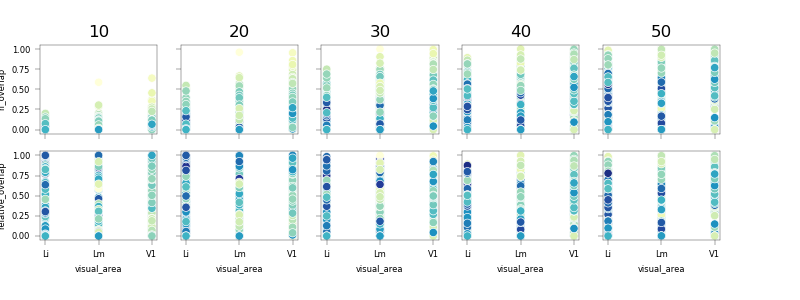

In [562]:
fig, axn = pl.subplots(2,5, figsize=(8,3), sharex=True, sharey=True)
for si, (sz, g) in enumerate(mean_by_size.groupby(['size'])):
    ax=axn[0, si]
    sns.scatterplot(x='visual_area', y='rf_overlap', hue='fwhm_avg', #size='fwhm_avg',
                 data=g, palette=rf_cmap,  ax=ax, hue_norm=(rf_smin, rf_smax),
                 x_jitter=True, markers='.') #order=visual_areas)
    ax.set_title(sz)
    
    ax=axn[1, si]
    sns.scatterplot(x='visual_area', y='relative_overlap', hue='fwhm_avg', #size='fwhm_avg',
                 data=g, palette=rf_cmap,  ax=ax, hue_norm=(rf_smin, rf_smax),
                 x_jitter=True, markers='.') #order=visual_areas)
for ax in axn.flat:
    ax.legend_.remove()
pl.subplots_adjust(left=0.05, right=0.9, bottom=0.2, top=0.85, wspace=0.2)

<IPython.core.display.Javascript object>


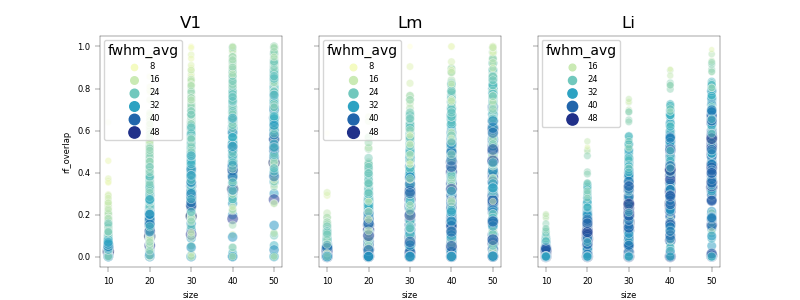

In [560]:
fig, axn = pl.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
for va, g in mean_by_size.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    sns.scatterplot(x='size', y='rf_overlap', hue='fwhm_avg', size='fwhm_avg',
                 data=g, palette=rf_cmap,  ax=ax, hue_norm=(rf_smin, rf_smax),
                 x_jitter=True, markers='.', alpha=0.5) #order=visual_areas)
    ax.set_title(va)
    

In [491]:
mean_by_size[(mean_by_size['size']==10) & (mean_by_size['rf_overlap']<0.05)]

,visual_area,datakey,cell,size,stimulus,area_overlap,rf_overlap,relative_overlap,morphlevel
60,Li,20190602_JC091_fov1,42.0,10,0_10_20_-8,12445.0,0.047538,0.998711,0
95,Li,20190602_JC091_fov1,62.0,10,0_10_20_-8,11845.0,0.047525,0.938047,0
100,Li,20190602_JC091_fov1,64.0,10,0_10_20_-8,12271.5,0.038197,0.976469,0
105,Li,20190602_JC091_fov1,65.0,10,0_10_20_-8,12445.0,0.030011,1.000000,0
110,Li,20190602_JC091_fov1,68.0,10,0_10_20_-8,5564.0,0.023427,0.444480,0
...,...,...,...,...,...,...,...,...,...
5145,V1,20190622_JC085_fov1,310.0,10,0_10_30_0,12353.0,0.044733,1.000000,0
5170,V1,20190622_JC085_fov1,336.0,10,0_10_30_0,12353.0,0.043446,1.000000,0
5210,V1,20190622_JC085_fov1,371.0,10,0_10_30_0,0.0,0.000000,0.000000,0
5225,V1,20191006_JC110_fov1,4.0,10,0_10_30_0,4345.5,0.032374,0.343988,0


In [492]:
va='Li'
dk='20190602_JC091_fov1'
rid = 42

# va='V1'
# dk='20190512_JC083_fov1'
# rid = 305

rfs_ = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
rf_screen = su.rf_to_screen(rid, rfs_[rfs_['cell']==rid])

overlaps_ = overlaps[(overlaps.visual_area==va) & (overlaps.datakey==dk)].copy()
    

In [493]:
stim = images['M%i' % mp].copy()

<IPython.core.display.Javascript object>


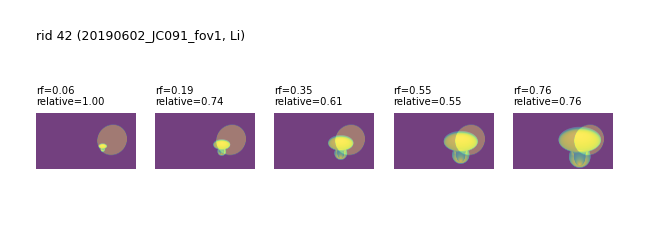

Text(0.05, 0.85, 'rid 42 (20190602_JC091_fov1, Li)')

In [514]:
%matplotlib notebook
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
cols = ['morphlevel', 'size', 'xpos', 'ypos']
mp = 0
xp = sdf['xpos'].unique()[0]
yp = sdf['ypos'].unique()[0]
sizes = sorted(sdf['size'].unique())
fig, axn = pl.subplots(1, 5, figsize=(8,3))
for ax, sz in zip(axn.flat, sizes):
    stimkey_str = '%i_%i_%i_%i' % (mp, sz, xp, yp)
    stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))
    # -----------------------------
    ax.imshow(rf_screen, alpha=0.5)
    ax.imshow(stim_screen, alpha=0.5)
    rf_perc = float(overlaps_[(overlaps_['cell']==rid) 
                   & (overlaps_['stimulus']==stimkey_str)]['rf_overlap'])
    rel_perc = float(overlaps_[(overlaps_['cell']==rid) 
                   & (overlaps_['stimulus']==stimkey_str)]['relative_overlap'])
    ax.set_title('rf=%.2f\nrelative=%.2f' % (rf_perc, rel_perc), 
                 loc='left', fontsize=8)
    ax.invert_yaxis()
    ax.axis('off')
pl.subplots_adjust(hspace=0.5, bottom=0.05, left=0.05, top=0.9, right=0.85)
fig.text(0.05, 0.85, 'rid %i (%s, %s)' % (rid, dk, va))

In [ ]:
# min_ = overlaps_.groupby(['cell'])['perc_overlap'].min().reset_index()
# pass_ = min_[min_['perc_overlap']>=overlap_thr]['cell'].unique()


In [517]:
overlap_thr=0.10
overlap_metric = 'relative_overlap'

for overlap_thr in [0, 0.25, 0.5, 0.75, 1.0]:
    min_overlaps = overlaps.groupby(['visual_area', 'datakey', 'cell'])\
                    [overlap_metric].min().reset_index()
    pass_overlaps = min_overlaps[min_overlaps[overlap_metric]>=overlap_thr]
    print('THR: %.2f %s' % (overlap_thr, overlap_metric))
    print(pass_overlaps[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area'])['cell'].count().to_markdown())


THR: 0.00 relative_overlap
| visual_area   |   cell |
|:--------------|-------:|
| Li            |    202 |
| Lm            |    278 |
| V1            |    615 |
THR: 0.25 relative_overlap
| visual_area   |   cell |
|:--------------|-------:|
| Li            |    143 |
| Lm            |    126 |
| V1            |    492 |
THR: 0.50 relative_overlap
| visual_area   |   cell |
|:--------------|-------:|
| Li            |     87 |
| Lm            |     73 |
| V1            |    324 |
THR: 0.75 relative_overlap
| visual_area   |   cell |
|:--------------|-------:|
| Li            |      1 |
| V1            |     10 |
THR: 1.00 relative_overlap
| visual_area   | cell   |
|---------------|--------|


In [518]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [522]:
cells_ =dec.get_cells_with_overlap(assigned_cells, sdata, overlap_thr=0.25)


print(cells_[['visual_area','datakey', 'cell']]\
       .drop_duplicates()['visual_area'].value_counts().to_markdown())             

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4
|    |   visual_area |
|:---|--------------:|
| V1 |           492 |
| Li |           143 |
| Lm |           126 |


In [391]:
min_overlaps[min_overlaps['size']==50]

,cell,stimulus,area_overlap,perc_overlap,visual_area,datakey,morphlevel,size


In [92]:
stim_polys = su.get_stimulus_polys(dk, experiment) 

In [93]:
o_=[]
for ri, rf_poly in rf_polys[['cell', 'poly']].values:
    res = su.cell_overlap_with_stimuli(ri, rf_poly, stim_polys)
    o_.append(res)
           

In [32]:
for si, spoly in enumerate(stim_polys['poly'].values):
    si

In [38]:
rfutils.calculate_overlap(rf_poly, spoly.buffer[0])

TypeError: 'method' object is not subscriptable

In [44]:
rf_poly + spoly

TypeError: unsupported operand type(s) for +: 'Polygon' and 'Polygon'

In [52]:
from shapely.validation import make_valid

ImportError: cannot import name 'make_valid' from 'shapely.validation' (/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/shapely/validation.py)

In [51]:
validation.make_valid


AttributeError: module 'shapely.validation' has no attribute 'make_valid'

# Visualize distribution of RF sizes

In [ ]:
rf_lim = 'percentile'
# cells_lim = dec.get_cells_with_matched_rfs(cells0, sdata, rf_lim='percentile')
rfdf = dec.get_rfdf(cells0, sdata, do_spherical_correction=False)
cells_RF = dec.get_cells_with_rfs(cells0, rfdf)
cells_lim, sz_limits = dec.limit_cells_by_rf(cells_RF, rf_lim=rf_lim)

sz_lower, sz_upper = sz_limits.loc['lower'].max(), lims.loc['upper'].min()
sz_limits

In [ ]:
print(cells_RF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
      ['visual_area'].value_counts().to_markdown())

In [ ]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y='std_avg', hue='visual_area', 
             data=cells_RF, ax=ax, order=visual_areas, 
             palette=area_colors, s=2, zorder=0)
sns.pointplot(x='visual_area', y='std_avg',
             data=cells_RF, ax=ax, order=visual_areas, join=False, ci='sd',
             estimator=np.median, color='k', markers='_', scale=1, zorder=1000,
             errwidth=1)

# sz_upper_lim=16.6
# sz_lower_lim=6.9
ax.axhline(y=sz_lower, color='k', ls=':', lw=0.5)
ax.axhline(y=sz_upper, color='k', ls=':', lw=0.5)
ax.legend_.remove()

fig.text(0.01, 0.95, 'Distribution of avg RF size, with median (%s)' % rf_lim)

pl.savefig(os.path.join(dst_dir, 'RF_sizes_%s.svg' % rf_lim))


In [ ]:
# Compare overlaps

In [ ]:
m1 = 'M%i' % 0
m2 = 'M%i' % 106
#images, impaths = su.load_stimuli(root='/n/home00/juliana.rhee', return_paths=True)
#print("im shape:", images['M0'].shape)
images = su.load_stimuli()
f, axn = pl.subplots(1,2, figsize=(5,2))
axn[0].imshow(images[m1]); axn[0].set_title(m1);
axn[1].imshow(images[m2]); axn[1].set_title(m2);


In [ ]:
## Example fov
dk = '20190602_JC091_fov1'
va='Li'
experiment='blobs'

In [ ]:
rid=15
rf_screen = su.rf_to_screen(rid, curr_rfs, resolution=[1920, 1080])
%matplotlib notebook
pl.figure()
pl.imshow(rf_screen)

In [ ]:
stim_polys, stim_screen = su.get_stimulus_polys

In [ ]:
rf = su.image_to_poly(rf_screen)
blob = su.image_to_poly(stim_screen.astype(np.uint8))
odf = rfutils.calculate_overlap(rf, blob, r1='rf', r2='blob')